<a href="https://colab.research.google.com/github/mquinteiro/learn-together/blob/master/test_dataInDrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import modules and functions

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from keras.utils import np_utils

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.1
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer 



# Load kaggle files

In [0]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json


In [9]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission
!kaggle competitions download -c learn-together -p input/

!unzip input/test.csv.zip -d input/
!unzip input/train.csv.zip -d input/

print(os.listdir('./input'))


kaggle.json
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
['train.csv.zip', 'sample_submission.csv.zip', 'test.csv.zip']
Archive:  input/sample_submission.csv.zip
caution: filename not matched:  input/test.csv.zip
caution: filename not matched:  input/train.csv.zip


# Prepare data

In [0]:
# Read the data
X = pd.read_csv('./input/train.csv', index_col='Id') 
X_test = pd.read_csv('./input/test.csv', index_col='Id')


y_enc = X['Cover_Type']
X.drop('Cover_Type', axis=1, inplace=True)

In [0]:
#remove unwanted columns
to_drop_columns = ['Soil_Type7','Soil_Type8','Soil_Type8','Soil_Type15','Soil_Type27','Soil_Type28','Soil_Type36']
X.drop(to_drop_columns, axis=1, inplace=True)
X_test.drop(to_drop_columns, axis=1, inplace=True)


In [4]:
# normalize data input
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer,MaxAbsScaler
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
X_norm = scaler.fit_transform(X)
X_test_norm = scaler.transform(X_test)


# create encoder to encode labels

encoder = LabelEncoder()
encoder.fit(y_enc)
y = np_utils.to_categorical(encoder.transform(y_enc))
print(y.shape)

(15120, 7)


In [5]:
print(np.min(X_norm[:3],axis=0))
print(y[0:3])

[-0.26787513 -0.71666667 -0.92307692 -0.68428891 -0.6        -0.88679245
  0.73228346  0.71612903  0.08870968  0.75060775  1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.        ]
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


In [0]:
from sklearn.model_selection import train_test_split

# split in  training and validating data
X_train, X_valid, y_train, y_valid = train_test_split(X_norm, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

# Define model

In [0]:
def create_model():
    drop_val=0.2
    # create model
    model = Sequential()
    model.add(Dense(100,  activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_val))
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_val))
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_val))
    model.add(Dense(7, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #8515
    #model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy']) #
    return model


estimator = KerasClassifier(
  build_fn=create_model, epochs=500, batch_size=2500, verbose=1)
from sklearn.model_selection import KFold

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

kfold = KFold(n_splits=4, shuffle=True, random_state=seed)

In [0]:
from keras.callbacks import EarlyStopping 

callbacks = [EarlyStopping(monitor='val_loss', patience=1000)]


# Execute model

In [9]:
# Note: even TPU is so slowwwwwww around 5 times slower than my GPU. Verbose=0 could speed it up?

model = create_model()
history2=model.fit(x=X_train, y=y_train,epochs=7500, validation_data=(X_valid, y_valid),batch_size=12096,callbacks=callbacks)


W0902 17:27:09.196075 140021476185984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 17:27:09.204369 140021476185984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0902 17:27:09.225627 140021476185984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 17:27:09.227793 140021476185984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 17:27:09.299590 140021476185984 deprecation_wrappe

Train on 12096 samples, validate on 3024 samples
Epoch 1/7500
12096/12096 [==============================] - 1s 118us/step - loss: 2.8458 - acc: 0.1415 - val_loss: 2.1617 - val_acc: 0.2097
Epoch 2/7500
12096/12096 [==============================] - 0s 15us/step - loss: 2.6181 - acc: 0.1814 - val_loss: 1.8903 - val_acc: 0.2735
Epoch 3/7500
12096/12096 [==============================] - 0s 15us/step - loss: 2.3638 - acc: 0.2181 - val_loss: 1.6663 - val_acc: 0.3912
Epoch 4/7500
12096/12096 [==============================] - 0s 15us/step - loss: 2.1425 - acc: 0.2636 - val_loss: 1.4961 - val_acc: 0.4673
Epoch 5/7500
12096/12096 [==============================] - 0s 15us/step - loss: 1.9486 - acc: 0.3131 - val_loss: 1.3744 - val_acc: 0.4987
Epoch 6/7500
12096/12096 [==============================] - 0s 15us/step - loss: 1.7912 - acc: 0.3642 - val_loss: 1.2921 - val_acc: 0.5205
Epoch 7/7500
12096/12096 [==============================] - 0s 15us/step - loss: 1.6739 - acc: 0.4131 - val_loss: 1.

In [0]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes = [1,2,3,4,5,6,7]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# View results

Confusion matrix and accuracy 


In [0]:
y_train_pred = encoder.inverse_transform(np.argmax(model.predict(X_train),axis=1))
y_valid_pred = encoder.inverse_transform(np.argmax(model.predict(X_valid),axis=1))

Normalized confusion matrix
Normalized confusion matrix
Confusion matrix, without normalization


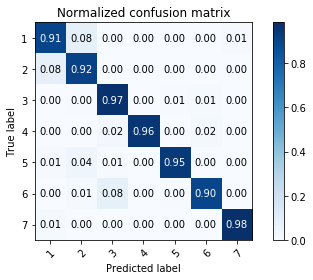

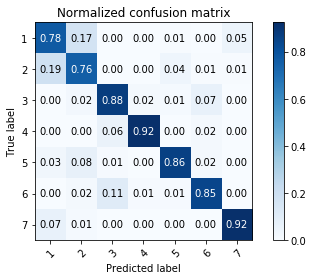

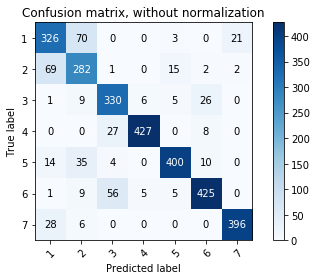

In [13]:
plot_confusion_matrix(y_train_pred, encoder.inverse_transform(np.argmax(y_train,axis=1)),7,normalize=True)
plot_confusion_matrix(y_valid_pred, encoder.inverse_transform(np.argmax(y_valid,axis=1)),7,normalize=True)
plot_confusion_matrix(y_valid_pred, encoder.inverse_transform(np.argmax(y_valid,axis=1)),7,normalize=False)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


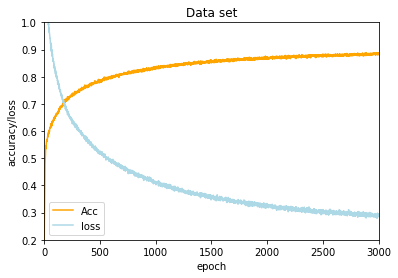

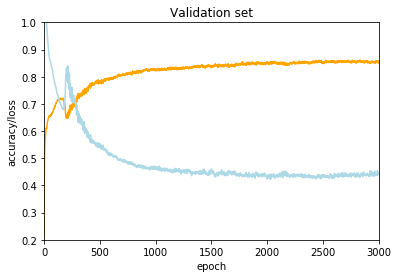

              precision    recall  f1-score   support

           1       0.78      0.74      0.76       439
           2       0.76      0.69      0.72       411
           3       0.88      0.79      0.83       418
           4       0.92      0.97      0.95       438
           5       0.86      0.93      0.90       428
           6       0.85      0.90      0.87       471
           7       0.92      0.95      0.93       419

    accuracy                           0.86      3024
   macro avg       0.85      0.85      0.85      3024
weighted avg       0.85      0.86      0.85      3024

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               4900      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
___________________________________________________

In [14]:
#With Adam Best historic, dropout 0.2 

import matplotlib.pyplot as plt
# summarize history for accuracy
print(history2.history.keys())
plt.plot(history2.history['acc'],color='orange',label="Acc")
plt.plot(history2.history['loss'],color='lightblue',label="loss")
plt.legend()
plt.title('Data set')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.ylim([0.2, 1.00])
plt.xlim([0, 3000])
plt.show()


plt.plot(history2.history['val_acc'],color='orange',label="Acc")
plt.plot(history2.history['val_loss'],color='lightblue',label="loss")
plt.title('Validation set')
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.ylim([0.2,.6])
plt.ylim([0.2, 1.00])
plt.xlim([0, 3000])
plt.show()


validation_result = encoder.inverse_transform(np.argmax(model.predict(X_valid),axis=1))
print(classification_report(encoder.inverse_transform(np.argmax(y_valid,axis=1)), validation_result))
model.summary()

# Generate submission file



In [0]:
result = model.predict(X_test_norm)
np.argmax(result,axis=1).shape
np.sum(result,axis=0)
output = pd.DataFrame({'Cover_Type': encoder.inverse_transform(np.argmax(result,axis=1)), 'Id': X_test.index}, columns=['Id','Cover_Type'])

output.to_csv('submission_model_dropingcols.csv', index=False)

# References and links

[Use Colab with kaggle](https://colab.research.google.com/drive/17MsV4f8Bap8y2MU8BcKBNXRdTNE2ftP3)
